# 011. Training and explaining the transport model

## Overview
We want to build our machine-learning model based on two fundamental observations:
- If there is no source causing local mass-influx, the discharge at a gridpoint is determined by the upstream points.
- If there is a rise in river levels/discharge that is not due to transport from upstream points, then it is from a local influence.

This motivates splitting the flood forecast model into two parts:
1. The prediction of discharge at some point at day $t$, is possible using the upstream points' discharge of the previous days $\{$t-1, t-2, t-3$\}$, given that there is no local contribution. 

We suspect that a large portion of the local contribution is due to precipitation, therefore we exclude rainy days from the training dataset for this model.

2. The residual, i.e. the quantity that is not due to inflow from other river gridpoints, is modelled using ERA5 data. The model itself is designed to forecast the residual for one day, so that it is sufficient to select predictor gridpoints that are in the nearby surroundings. We expect precipitation to have the largest impact. Snow melting could be represented by some combination of airmass temperature (relative topography) and a snow cover variable.

Therefore we split the discharge forecasts into two models:
- The `TransportModel` is responsible for advection of water from upstream river to downstream river gridpoints. 
- The`LocalModel` is responsible for the difference to observed values. It is driven by nearby gridpoints' information.

## Training the transport model

Let's import some packages.

In [1]:
import os, warnings, sys
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA

import dask
dask.config.set(scheduler='threading')

import xarray as xr
from dask.diagnostics import ProgressBar
from joblib import Parallel

To import our custom packages, we are setting the PYTHONPATH in `link_src`.

In [2]:
sys.path.append('../../')
from python.aux.utils import open_data
from python.aux.ml_flood_config import path_to_data
from python.aux.floodmodels import FlowModel

Using TensorFlow backend.
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint1

For the TransportModel, we need GloFAS reanalysis as predictor and predictand and the ERA5 dataset to find training periods with little precipitation to avoid influences that are covered by the LocalModel.

In [3]:
era5 = open_data(path_to_data+'danube/', kw='era5')

In [4]:
glofas = open_data(path_to_data+'danube/', kw='glofas_ra')

We prepare the predictor data, i.e. features by converting units and interpolating the data to the other grid so that we can use masked operations on it afterwards.

In [5]:
if 'tp' in era5:
    tp = era5['tp']*1000
else:
    tp = (era5['cp']+era5['lsp'])*1000
tp.name = 'total precip [mm]'
tp = tp.interp(latitude=glofas.latitude,
               longitude=glofas.longitude)

## Prepare training data for the TransportModel
The predictors and predictand are as follows:
predictors = discharge at upstream river gridpoints of time (t-1, t-2, t-3)
predicand = discharge (t)

To achieve this, we add the discharge three times as new variable to the training data `X`. Each time the data is shifted by one day. Finally we drop the discharge at the current day $t$ so that we are left with 3 variables, e.g. discharges at (t-1, t-2, t-3).

In [6]:
from python.aux.utils_floodmodel import add_shifted_variables

In [7]:
shifts = range(1,4)
X = add_shifted_variables(glofas, shifts, variables='all')
X = X.drop('dis')  # current dis is to be predicted, is not a feature

y = glofas['dis']  # just this variable as dataarray

In [8]:
X

<xarray.Dataset>
Dimensions:    (latitude: 30, longitude: 130, time: 13879)
Coordinates:
  * longitude  (longitude) float64 7.05 7.15 7.25 7.35 ... 19.75 19.85 19.95
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 47.25 47.15 47.05
  * time       (time) datetime64[ns] 1981-01-02 1981-01-03 ... 2019-01-01
Data variables:
    dis-1      (time, latitude, longitude) float32 dask.array<shape=(13879, 30, 130), chunksize=(8035, 30, 130)>
    dis-2      (time, latitude, longitude) float32 dask.array<shape=(13879, 30, 130), chunksize=(8035, 30, 130)>
    dis-3      (time, latitude, longitude) float32 dask.array<shape=(13879, 30, 130), chunksize=(8035, 30, 130)>
Attributes:
    CDI:          Climate Data Interface version 1.6.4rc4 (http://code.zmaw.d...
    Conventions:  CF-1.4
    history:      Thu Jun 13 19:25:04 2019: cdo mergetime /home/srvx11/lehre/...
    CDO:          Climate Data Operators version 1.6.4rc7 (http://code.zmaw.d...

Next, we select the training and validation periods,

In [9]:
N_train = dict(time=slice(None, '1990'))
N_valid = dict(time=slice('1990', '1995'))

We determine the location to save the model object and plots about the quality of training and the used features in space (the upstream river gridpoints).

In [10]:
# kind, lat, lon will be replaced!
main_dir = '/home/srvx11/lehre/users/a1254888/ipython/ml_flood/'
ff_mod = main_dir+'/models/flowmodel/danube/kind/point_lat_lon_flowmodel.pkl'
ff_hist = main_dir+'/models/flowmodel/danube/kind/point_lat_lon_history.png'
ff_valid = main_dir+'/models/flowmodel/danube/kind/point_lat_lon_validation.png'
ff_upstream = main_dir+'/models/flowmodel/danube/kind/point_lat_lon_upstream.png'

### Model selection
Now we can select which model to use for the TransportModel, modelling the waterflow without precipitation, etc. 

We choose the neural network here, where scaling is done within the model, but we could use other models with feature scaling and feature selection (principal component analysis) too.

In [11]:
#pipe = Pipeline([('scaler', StandardScaler()),
#                 #('pca', PCA(n_components=6)),
#                 ('model', FlowModel('Ridge', dict(alphas=np.logspace(-3, 2, 6)))),])

model = FlowModel('neural_net', dict(epochs=1000,
                                      ))
pipe = Pipeline([('model', model),])

Instructions for updating:
Colocations handled automatically by placer.


### For the spatial feature selection,
we prepare a mask with all relevant gridpoints
- river gridpoints (discharge greater than some threshold [m^3/s] and
- within Danube catchment

In [12]:
from python.aux.utils_floodmodel import get_mask_of_basin

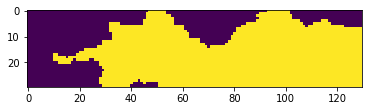

In [13]:
danube_gridpoints = get_mask_of_basin(glofas['dis'].isel(time=0), 'Danube')
plt.imshow(danube_gridpoints.astype(int))
plt.show()

In [14]:
def select_riverpoints(dis):
    return (dis > 10)

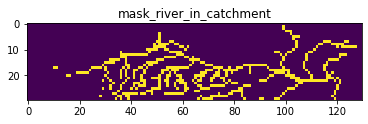

In [15]:
dis_map_mean = glofas['dis'].mean('time')
is_river = select_riverpoints(dis_map_mean)
mask_river_in_catchment = is_river & danube_gridpoints

plt.imshow(mask_river_in_catchment.astype(int))
plt.title('mask_river_in_catchment')
plt.show()

## Preparing the training tasks to run in parallel

To train the gridpoints in parallel instead of one after another, we iterate over the array and append a `delayed` function call to the `task_list`. This task list can then be worked on by `joblib`'s `Parallel()` function.

In [16]:
from python.aux.floodmodels import train_flowmodel

def mkdir(d):
    if not os.path.isdir(d):
        os.makedirs(d)
        
def replace(string: str, old_new: dict):
    for o, n in old_new.items(): 
        string = string.replace(o, str(n))
    return string

In [17]:
mkdir(os.path.dirname(ff_mod).replace('kind', model.kind))

grid = mask_river_in_catchment
lats = grid.latitude.values
lons = grid.longitude.values

is_river_in_catchment = grid.values
lons, lats = np.meshgrid(lons, lats)

lats = lats[is_river_in_catchment]
lons = lons[is_river_in_catchment]


N_upstream 18
(933, 54) (933,)
(596, 54) (596,)
Instructions for updating:
Use tf.cast instead.


/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
../../python/aux/floodmodels.py:272: UserWarning: 'val_loss'
  warnings.warn(str(e))


AttributeError: 'numpy.ndarray' object has no attribute 'values'

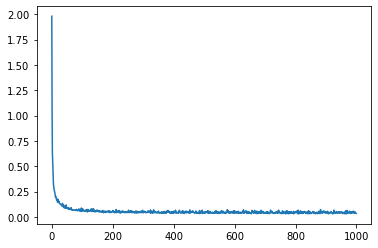

In [18]:
task_list = []
#train_flowmodel = dask.delayed(train_flowmodel)  # make it a delayed function

for lat, lon in zip(lats, lons):    
    f_mod = replace(ff_mod, dict(lat=lat, lon=lon, kind=model.kind))
    f_hist = replace(ff_hist, dict(lat=lat, lon=lon, kind=model.kind))
    f_valid = replace(ff_valid, dict(lat=lat, lon=lon, kind=model.kind))
    f_upstream = replace(ff_upstream, dict(lat=lat, lon=lon, kind=model.kind))

    #if not os.path.isfile(f_mod):  # if model does not yet exist

    task_list.append(train_flowmodel(X, y, pipe,
                                     lat, lon, 
                                     tp, mask_river_in_catchment,
                                     N_train, N_valid,
                                     f_mod, f_hist, f_valid, f_upstream, debug=True))

How many tasks are there?

In [ ]:
len(task_list)

### Actual computation
The actual computation can be done for example with these two packages. We found `joblib` to work easier out of the box because we have independent computations.

dask:
1. Import `dask`
2. Decorate the function to parallelize with `@dask.delayed`
3. Call
``with ProgressBar():
    dask.compute(task_list)``
    
joblib:
1. Import `from joblib import delayed, Parallel`
2. Decorate the function to parallelize with `@delayed`
3. Call
``Parallel(n_jobs=20, verbose=10)(task_list)``

In [ ]:
with ProgressBar():
    with dask.config.set(scheduler='synchronous'):
        dask.compute(task_list)

The work is now finished and saved in our folder.

In [ ]:
files = os.listdir(os.path.dirname(f_mod))
len(files)

Let's look at some of the results:

In [ ]:
from IPython.display import Image
ddir = "../models/flowmodel/danube/neural_net-1/"

In [ ]:
Image(ddir+'point_48.05_10.150000000000034_history.png')

In [ ]:
Image(ddir+'point_48.05_10.150000000000034_validation.png')

In [ ]:
Image(ddir+'point_49.75_11.75_upstream.png')

In [ ]:
Image(ddir+'point_47.75_17.65_upstream.png')

In [ ]:
Image(ddir+'point_48.35_18.25_upstream.png')